In [79]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils import calculate_metrics

# Original Data

In [80]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True)
    }

    # Initialize the model with the current hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-08-30 11:33:13,476] A new study created in memory with name: no-name-f183594f-8c79-48c8-b4c9-f28bdb7395b4
[I 2024-08-30 11:33:13,730] Trial 0 finished with value: 0.7686728395061729 and parameters: {'n_estimators': 172, 'max_depth': 2, 'learning_rate': 0.12198392226237416, 'subsample': 0.9822863990611277, 'colsample_bytree': 0.9605261864219063, 'gamma': 0.3959804469811079, 'lambda': 0.01704639063840062, 'alpha': 0.06553681883391023}. Best is trial 0 with value: 0.7686728395061729.
[I 2024-08-30 11:33:14,103] Trial 1 finished with value: 0.7975823045267489 and parameters: {'n_estimators': 234, 'max_depth': 10, 'learning_rate': 0.015997203434718346, 'subsample': 0.715503103953495, 'colsample_bytree': 0.6239118505905717, 'gamma': 4.474505656982135, 'lambda': 0.016770889701098416, 'alpha': 0.0009751071009592295}. Best is trial 1 with value: 0.7975823045267489.
[I 2024-08-30 11:33:14,311] Trial 2 finished with value: 0.7934670781893004 and parameters: {'n_estimators': 208, 'max_dept

Best hyperparameters:  {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.05606915965946704, 'subsample': 0.6515419156375615, 'colsample_bytree': 0.5981134283769739, 'gamma': 1.4313324071972793, 'lambda': 3.100892703860783e-07, 'alpha': 1.800642383048582e-05}


In [82]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [83]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()


In [84]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()

In [85]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

In [86]:
#test the model with the best hyperparameters
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

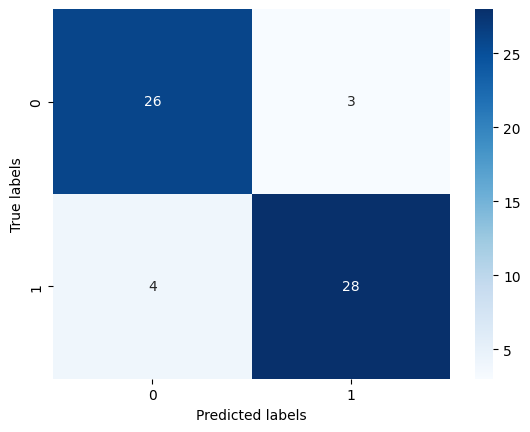

In [87]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [88]:

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))


Accuracy:  0.8852459016393442
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



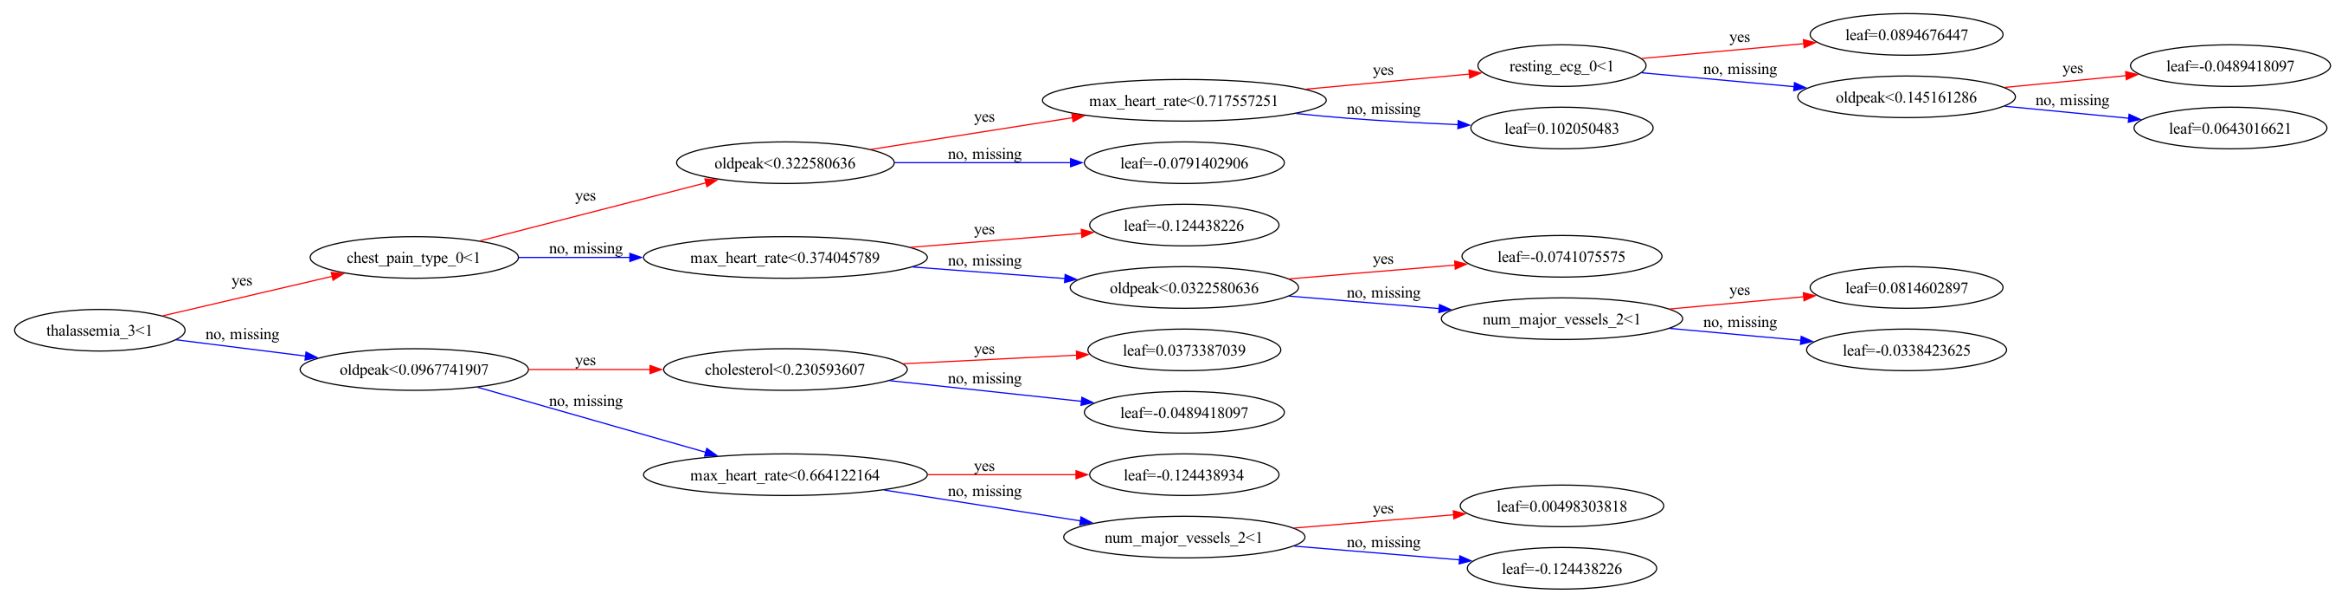

In [89]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model,num_trees=0,rankdir="LR",ax=ax)
plt.show()

In [90]:
calculate_metrics(y_test, y_pred, 'XGBoost')

Metrics saved to ./results/original/XGBoost


# Resampled

In [91]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [92]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True)
    }

    # Initialize the model with the current hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-08-30 11:33:56,962] A new study created in memory with name: no-name-422882f4-3301-481b-934e-4cb458f35a42
[I 2024-08-30 11:33:57,080] Trial 0 finished with value: 0.8514019505398815 and parameters: {'n_estimators': 94, 'max_depth': 8, 'learning_rate': 0.15788515224830063, 'subsample': 0.7421842481613925, 'colsample_bytree': 0.7763812572217168, 'gamma': 4.653718550753145, 'lambda': 3.951240696130161e-08, 'alpha': 0.4372127282953625}. Best is trial 0 with value: 0.8514019505398815.
[I 2024-08-30 11:33:57,397] Trial 1 finished with value: 0.8514019505398815 and parameters: {'n_estimators': 277, 'max_depth': 2, 'learning_rate': 0.032190325068367893, 'subsample': 0.6945648424467805, 'colsample_bytree': 0.9024733762835055, 'gamma': 3.328091249206704, 'lambda': 4.553221847767043e-07, 'alpha': 0.17738345570190242}. Best is trial 0 with value: 0.8514019505398815.
[I 2024-08-30 11:33:57,613] Trial 2 finished with value: 0.8361198188784394 and parameters: {'n_estimators': 159, 'max_depth'

Best hyperparameters:  {'n_estimators': 260, 'max_depth': 3, 'learning_rate': 0.1012324808969114, 'subsample': 0.5330560272850091, 'colsample_bytree': 0.7683249337422581, 'gamma': 3.201139513095333, 'lambda': 1.1958887240234264, 'alpha': 0.13374952487840222}


In [93]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()



In [94]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()


In [95]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()



In [96]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

In [97]:
#test the model with the best hyperparameters
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

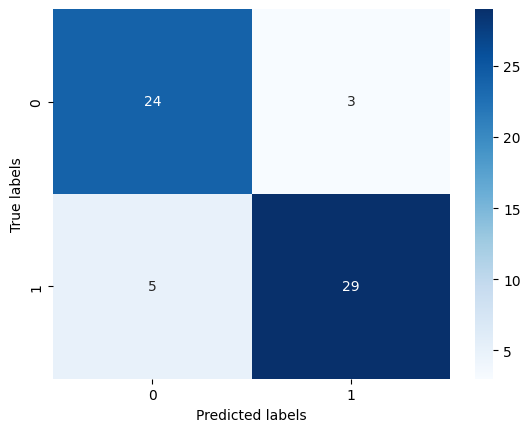

In [98]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



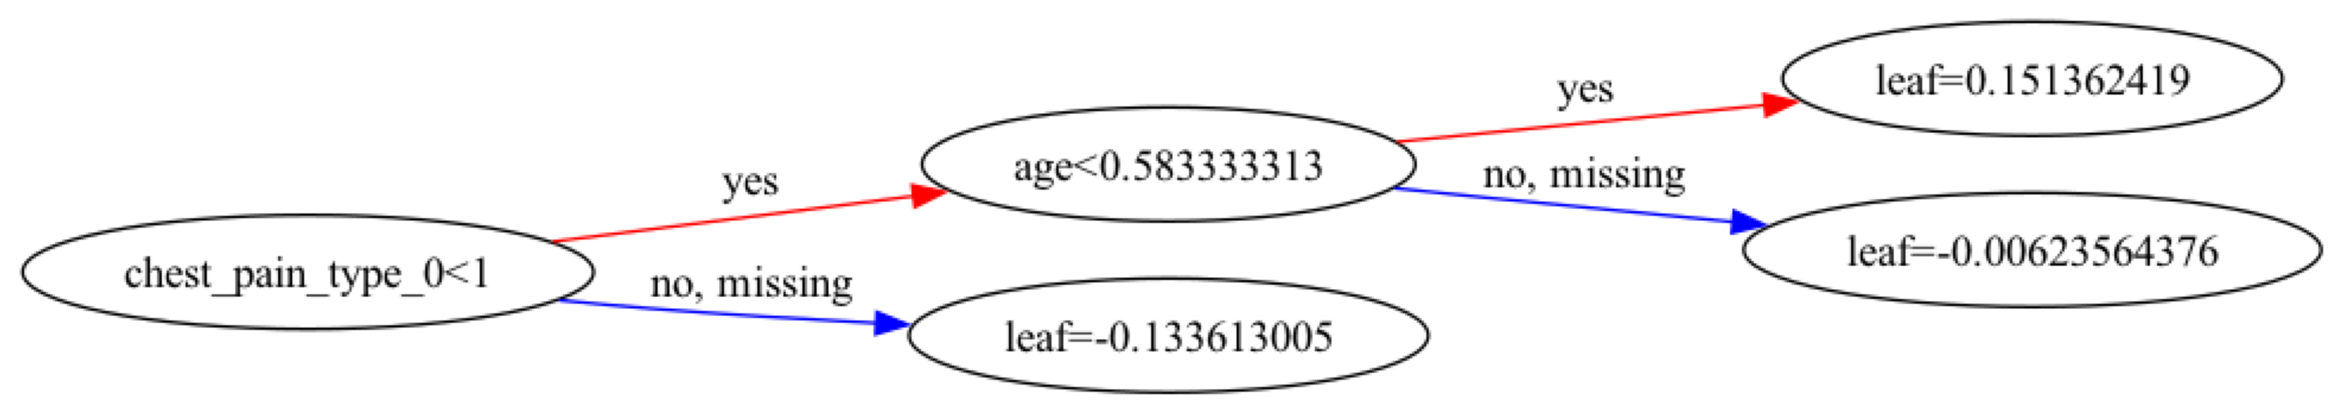

In [100]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model,num_trees=0,rankdir="LR",ax=ax)
plt.show()

In [101]:
calculate_metrics(y_test, y_pred, 'XGBoost', True)

Metrics saved to ./results/rebalanced/XGBoost
